Introduction

# Introduction

Building a multi-class image classifier to:

-Identify Sarawakian wildlife species from camera trap images

    Run all imports and use the print dataset to verify the dataset and classes
    Run the Data Preperation
    Run either build ResNet50 or MobilNetV2
    Run both Traning and Evalution
    Run either Deep Learning No.1 (MobileNetV2) or No.2 (ResNet50) based on your model choice.

# Importing the files/datasets

Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary libraries for image processing, encoding labels, and data handling


In [ ]:
# Step 2: Imports
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter

Load and preprocess images from a nested folder structure, resizing and flattening each image

Returns image data (X) and corresponding labels (y) for a given split (e.g., 'train' or 'val')


In [ ]:
def load_split_from_nested_dataset(root_path, split='train', img_size=(256, 256)):
    X = []
    y = []
    class_names = sorted(os.listdir(root_path))

    for label in class_names:
        split_folder = os.path.join(root_path, label, split)
        if not os.path.isdir(split_folder):
            continue
        for img_name in os.listdir(split_folder):
            img_path = os.path.join(split_folder, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)  # Resize to 256x256
                img_array = np.array(img).flatten()  # Flatten the image to a vector
                X.append(img_array)
                y.append(label)
            except Exception as e:
                print(f"Could not process {img_path}: {e}")
    return np.array(X), np.array(y)


define the directory

In [ ]:
# Your top-level dataset directory
dataset_root = '/content/drive/My Drive/Colab Notebooks/plant_dataset'


Load and preprocess image data and labels for training, validation, and test splits from the dataset


In [ ]:
# Load train, validation, and test splits
X_train, y_train = load_split_from_nested_dataset(dataset_root, split='train')
X_val, y_val = load_split_from_nested_dataset(dataset_root, split='val')
X_test, y_test = load_split_from_nested_dataset(dataset_root, split='test')


Create a label encoder, train it using all the labels, convert the labels into numbers, and then print the mapping of classes to their numeric codes.

Label encoding is used to convert categorical labels (like class names) into numbers that machine learning models can understand and work with.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Label encoding
le = LabelEncoder()
le.fit(np.concatenate([y_train, y_val, y_test]))

y_train_enc = le.transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Show class-to-index mapping
print("Class to index mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Class to index mapping: {np.str_('flower_ball_moss'): np.int64(0), np.str_('flower_bee_balm'): np.int64(1), np.str_('flower_blackberry_lily'): np.int64(2), np.str_('flower_bougainvillea'): np.int64(3), np.str_('flower_bromelia'): np.int64(4), np.str_('flower_pelargonium'): np.int64(5)}


Prints dataset shapes and class counts to check data size and label distribution for train, validation, and test sets.

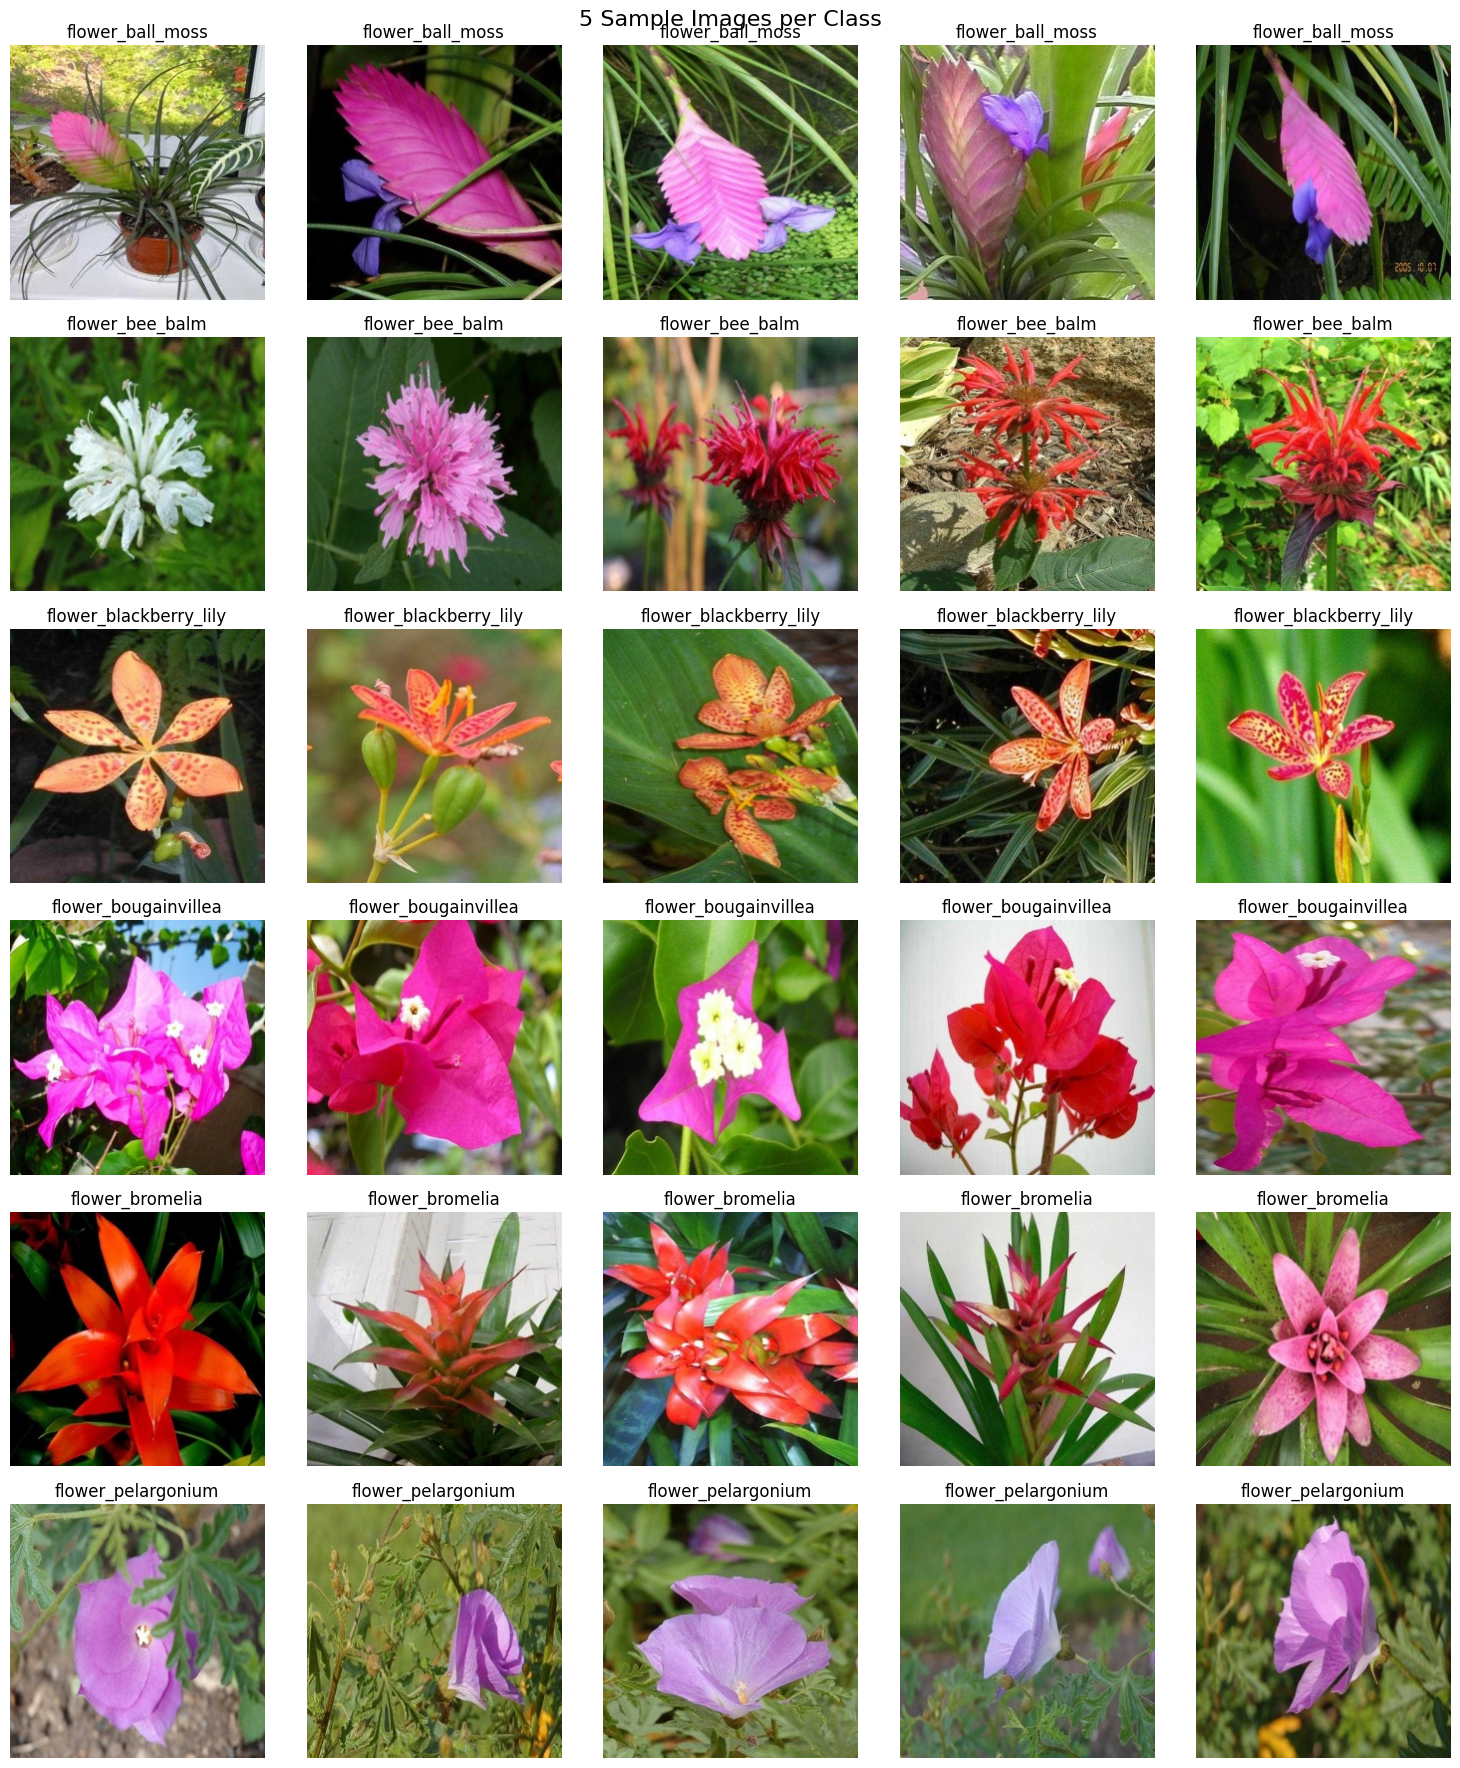

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Group images by original class name
images_by_class = defaultdict(list)

# Convert encoded labels back to class names
y_train_labels = le.inverse_transform(y_train_enc)

# Collect up to 5 images per class
for img, label in zip(X_train, y_train_labels):
    if len(images_by_class[label]) < 5:
        images_by_class[label].append(img)
    # Stop early if we have 5 for every class
    if all(len(imgs) >= 5 for imgs in images_by_class.values()):
        if len(images_by_class) == len(le.classes_):
            break

# Plotting
num_classes = len(images_by_class)
plt.figure(figsize=(15, 3 * num_classes))

for row_idx, (label, images) in enumerate(sorted(images_by_class.items())):
    for col_idx, img in enumerate(images):
        plt_idx = row_idx * 5 + col_idx + 1
        plt.subplot(num_classes, 5, plt_idx)
        reshaped_img = img.reshape(256, 256, 3)
        plt.imshow(reshaped_img.astype(np.uint8))  # Optional cast to uint8 for visualization
        plt.title(f"{label}")
        plt.axis('off')

plt.suptitle("5 Sample Images per Class", fontsize=16)
plt.tight_layout()
plt.show()


Prints class distributions and shapes of train, validation, and test datasets to verify data balance and size.

In [ ]:
# Step 8: Check distributions
print("Train class distribution:", Counter(y_train))
print("Val class distribution:", Counter(y_val))
print("Test class distribution:", Counter(y_test))

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

Train class distribution: Counter({np.str_('flower_bougainvillea'): 68, np.str_('flower_bee_balm'): 45, np.str_('flower_pelargonium'): 41, np.str_('flower_bromelia'): 37, np.str_('flower_blackberry_lily'): 27, np.str_('flower_ball_moss'): 26})
Val class distribution: Counter({np.str_('flower_pelargonium'): 19, np.str_('flower_ball_moss'): 14, np.str_('flower_bee_balm'): 13, np.str_('flower_blackberry_lily'): 13, np.str_('flower_bougainvillea'): 11, np.str_('flower_bromelia'): 5})
Test class distribution: Counter({np.str_('flower_bougainvillea'): 44, np.str_('flower_bromelia'): 18, np.str_('flower_pelargonium'): 8, np.str_('flower_bee_balm'): 7, np.str_('flower_ball_moss'): 5, np.str_('flower_blackberry_lily'): 5})
Shapes:
X_train: (244, 196608)
X_val: (75, 196608)
X_test: (87, 196608)


# Data Preprocessing for CNN Image Classification

Library Imports: It imports necessary libraries for deep learning (TensorFlow/Keras), data preprocessing, visualization (Matplotlib, Seaborn), and evaluation (Scikit-learn).

Function to Reshape Images: The reshape_for_cnn function reshapes flattened image data into 3D arrays with dimensions suitable for CNN input (256x256 RGB images).

Data Preparation:

    Training, validation, and test sets are reshaped to 3D format.

    Pixel values are normalized to a [0, 1] range to aid in faster and more stable training.

    Target labels are converted to one-hot encoded vectors for multi-class classification.

Output Check: The shapes of the CNN-ready datasets are printed to confirm the preprocessing steps were successful.

In [ ]:
# Import necessary libraries for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# 1. Reshape data for CNN input (from flattened to 3D)
def reshape_for_cnn(X_data, img_size=(256, 256)):
    return X_data.reshape(-1, img_size[0], img_size[1], 3)

# Reshape the data
X_train_cnn = reshape_for_cnn(X_train)
X_val_cnn = reshape_for_cnn(X_val)
X_test_cnn = reshape_for_cnn(X_test)

# Normalize pixel values to [0,1]
X_train_cnn = X_train_cnn / 255.0
X_val_cnn = X_val_cnn / 255.0
X_test_cnn = X_test_cnn / 255.0

# Convert labels to one-hot encoding
num_classes = len(le.classes_)
y_train_onehot = to_categorical(y_train_enc, num_classes)
y_val_onehot = to_categorical(y_val_enc, num_classes)
y_test_onehot = to_categorical(y_test_enc, num_classes)

print("CNN input shapes:")
print("X_train_cnn:", X_train_cnn.shape)
print("X_val_cnn:", X_val_cnn.shape)
print("X_test_cnn:", X_test_cnn.shape)


CNN input shapes:
X_train_cnn: (244, 256, 256, 3)
X_val_cnn: (75, 256, 256, 3)
X_test_cnn: (87, 256, 256, 3)


#Build MobileNetV2

In [ ]:
# 3. Transfer Learning with MobileNetV2
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model layers
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

#Training

Defines a training function that trains a model with early stopping, learning rate reduction, and model checkpoint callbacks, plots training/validation accuracy and loss, saves the best model and training history plot, and returns the trained model and its training history.

Same trainning function is used for both model

In [ ]:
# 2. Training Function with Callbacks
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=30, batch_size=32):
    save_dir = f'/content/drive/My Drive/models/{model_name}'
    os.makedirs(save_dir, exist_ok=True)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
        ModelCheckpoint(f'{save_dir}/{model_name}_best.h5', save_best_only=True, monitor='val_accuracy')
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{save_dir}/{model_name}_training_history.png')
    plt.show()

    return model, history


Defines a function to evaluate a trained model by computing accuracy, printing and saving a classification report, visualizing and saving the confusion matrix, displaying sample test images with predicted vs. true labels, and saving all results to Google Drive.


Same evaluate model is used for both model

#Evaluate

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, X_test, y_test, y_test_categorical, class_names, model_name):
    # Set up Google Drive save path
    save_dir = f'/content/drive/My Drive/models/{model_name}'
    os.makedirs(save_dir, exist_ok=True)

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = y_test

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    report_text = classification_report(y_true, y_pred, target_names=class_names)
    print(report_text)

    # Save classification report
    with open(f'{save_dir}/{model_name}_classification_report.txt', 'w') as f:
        f.write(f"Accuracy: {accuracy:.4f}\n\n")
        f.write(report_text)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/{model_name}_confusion_matrix.png')
    plt.show()

    # Sample predictions (one per class)
    plt.figure(figsize=(20, 10))
    shown_classes = set()
    samples_shown = 0

    for i in range(len(X_test)):
        true_label = y_true[i]
        if true_label not in shown_classes:
            shown_classes.add(true_label)

            plt.subplot(2, 5, samples_shown + 1)
            img = X_test[i].reshape(256, 256, 3)

            # Convert back to uint8 if normalized
            img_display = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)

            plt.imshow(img_display)
            predicted_class = class_names[y_pred[i]]
            true_class = class_names[true_label]
            title_color = 'green' if predicted_class == true_class else 'red'
            plt.title(f"Pred: {predicted_class}\nTrue: {true_class}", color=title_color)
            plt.axis('off')

            samples_shown += 1
            if samples_shown == 10:
                break

    plt.tight_layout()
    plt.savefig(f'{save_dir}/{model_name}_sample_predictions.png')
    plt.show()

    return accuracy, y_pred, y_pred_prob


This code builds and trains a MobileNetV2 model on the CNN-preprocessed training data, prints input and class information, runs training with specified epochs, and then evaluates the trained model on the test set, saving results and displaying metrics.


===== Training NASNetMobile =====
Input shape: (256, 256, 3)
Class names: ['flower_ball_moss' 'flower_bee_balm' 'flower_blackberry_lily'
 'flower_bougainvillea' 'flower_bromelia' 'flower_pelargonium']


/tmp/ipython-input-233521033.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4263 - loss: 1.8280

8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4472 - loss: 1.7595 - val_accuracy: 0.9067 - val_loss: 0.5289 - learning_rate: 0.0010
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9685 - loss: 0.1089

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9688 - loss: 0.1083 - val_accuracy: 0.9467 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9817 - loss: 0.0615

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9824 - loss: 0.0600 - val_accuracy: 0.9733 - val_loss: 0.1518 - learning_rate: 0.0010
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9973 - loss: 0.0220 - val_accuracy: 0.9733 - val_loss: 0.1124 - learning_rate: 0.0010
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9995 - loss: 0.0189

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9991 - loss: 0.0191 - val_accuracy: 0.9867 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9901 - loss: 0.0387 - val_accuracy: 0.9867 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 0.9867 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.9867 - val_loss: 0.0563 - learning_rate: 0.0010
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 0.0283 - val_accuracy: 0.9867 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9867 - val_loss: 0.0463 - learning_rate: 0.0010


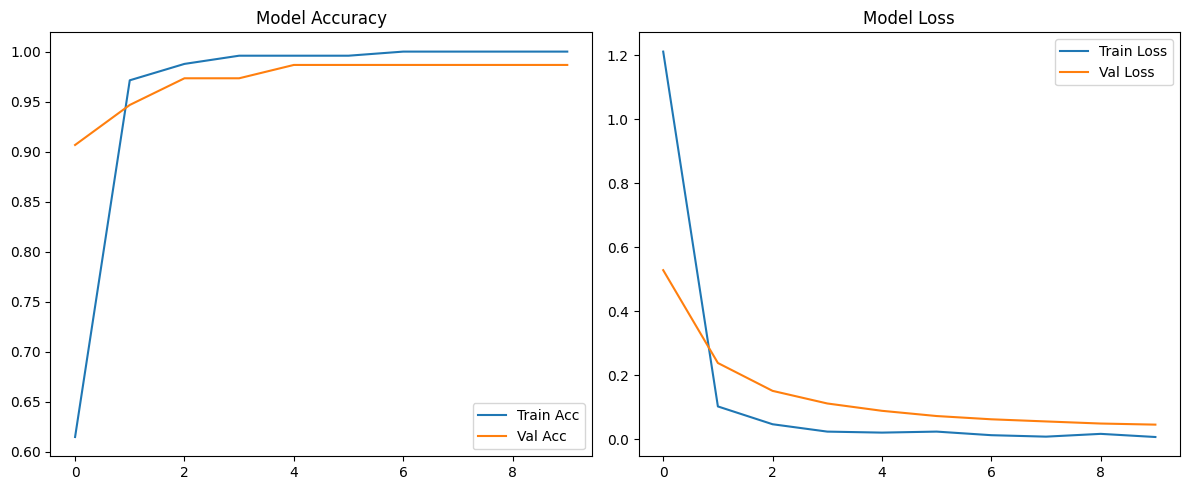

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
mobilenetv2_plant Accuracy: 0.9770

Classification Report:
                        precision    recall  f1-score   support

      flower_ball_moss       0.71      1.00      0.83         5
       flower_bee_balm       1.00      1.00      1.00         7
flower_blackberry_lily       1.00      1.00      1.00         5
  flower_bougainvillea       1.00      0.95      0.98        44
       flower_bromelia       1.00      1.00      1.00        18
    flower_pelargonium       1.00      1.00      1.00         8

              accuracy                           0.98        87
             macro avg       0.95      0.99      0.97        87
          weighted avg       0.98      0.98      0.98        87



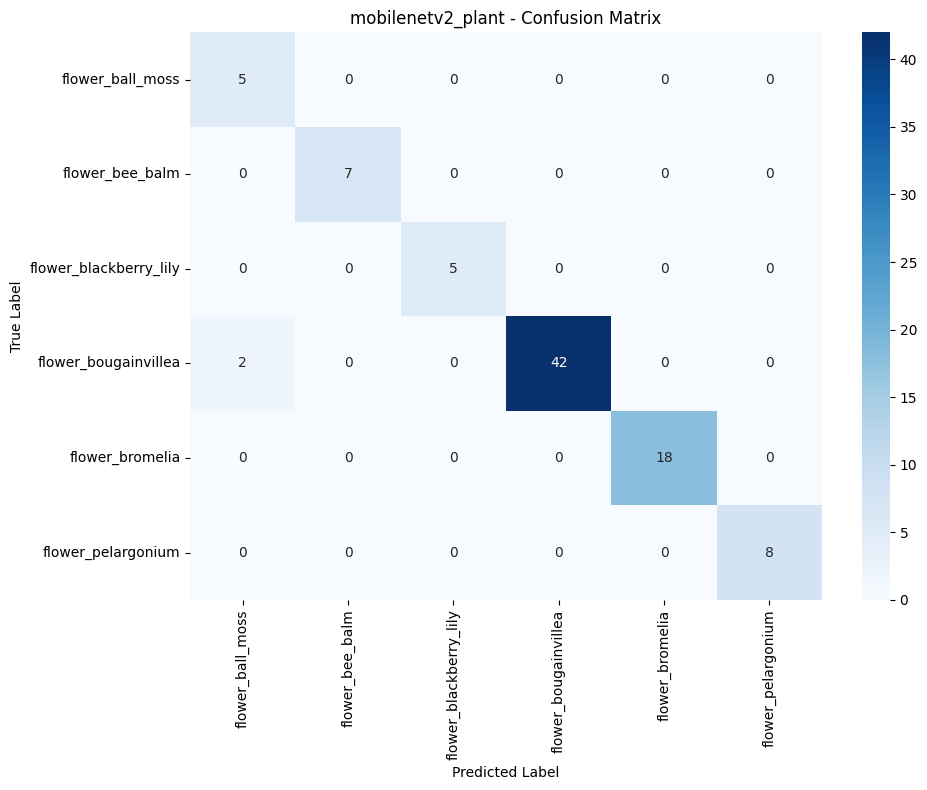

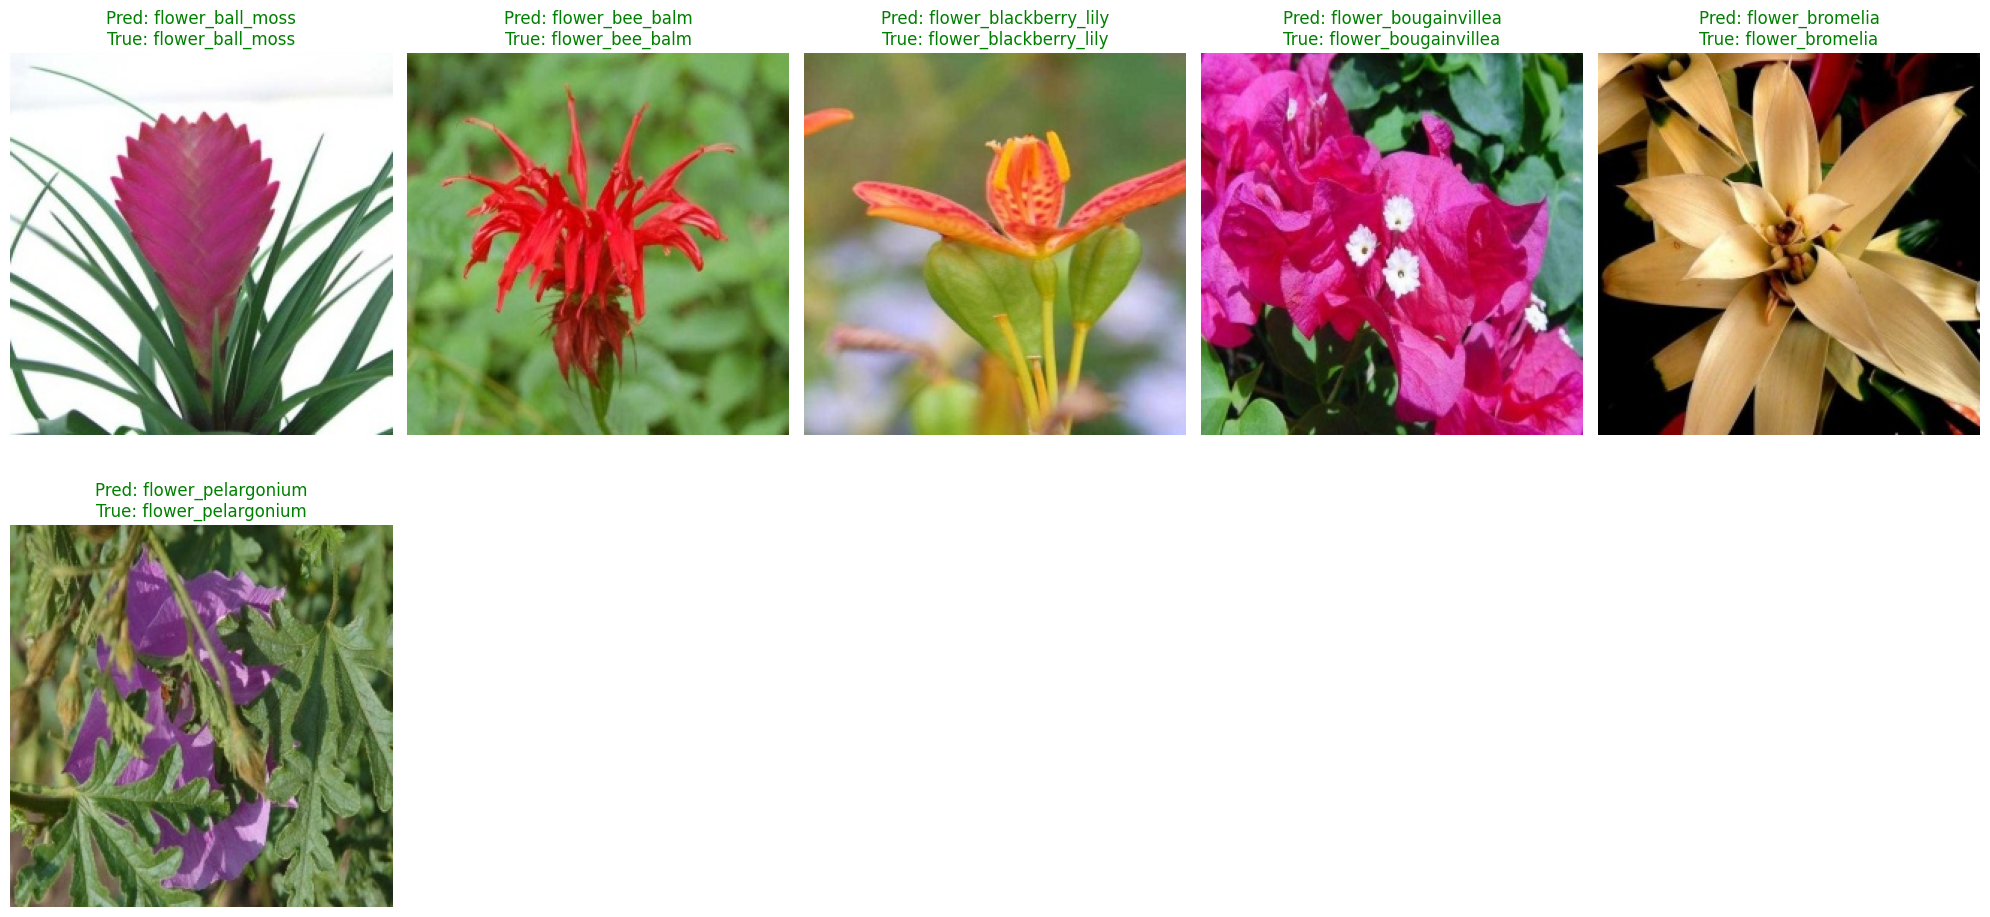

In [ ]:
# 3. Use It Together
# Build and train NASNetMobile
print("\n===== Training NASNetMobile =====")

input_shape = X_train_cnn.shape[1:]
print("Input shape:", input_shape)

# Get class names from the label encoder
class_names = le.classes_
print("Class names:", class_names)

model_name = 'mobilenetv2_plant'

mobilenet_model = build_mobilenet_model(input_shape, num_classes)
mobilenet_model, mobilenet_history = train_model(
    mobilenet_model,
    X_train_cnn, y_train_onehot,
    X_val_cnn, y_val_onehot,
    model_name=model_name,
    epochs=10
)

# Evaluate
accuracy, y_pred, y_pred_prob = evaluate_model(
    model=mobilenet_model,
    X_test=X_test_cnn,
    y_test=np.argmax(y_test_onehot, axis=1),
    y_test_categorical=y_test_onehot,
    class_names=class_names,
    model_name=model_name
)
